# PCA - Face Recognition

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.compose import make_column_selector
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats
from sklearn.svm import SVC
from sklearn.metrics import classification_report

In [ ]:
faces = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

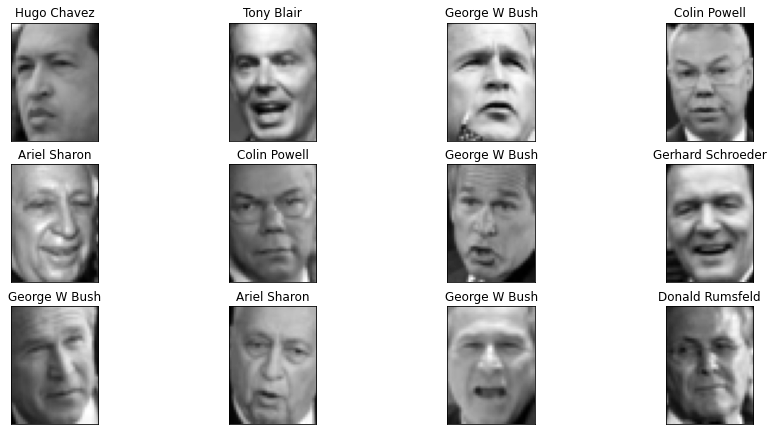

In [18]:
fig = plt.figure(figsize=(15,10))
for i in range(12):
    plt.subplot(4, 4, i + 1)
    plt.title(faces.target_names[faces.target[i]], size=12)
    plt.imshow(faces.images[i], cmap=plt.cm.gray)
    plt.xticks(())
    plt.yticks(())

## PCA applied

In [19]:
img_reshaped = np.reshape(faces.images, (1288, 50*37))
pca = PCA(n_components=150)
pca.fit(img_reshaped)

PCA(n_components=150)

In [20]:
pca.transform(img_reshaped).shape

(1288, 150)

In [21]:
data_projected = pca.transform(img_reshaped)
data_projected.shape

(1288, 150)

In [22]:
data_reconstructed = pca.inverse_transform(data_projected)
data_reconstructed.shape

(1288, 1850)

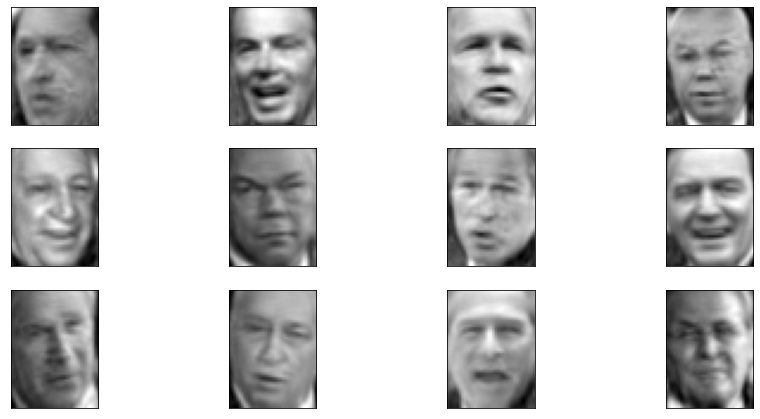

In [23]:
img_reconstructed = np.reshape(data_reconstructed, (1288, 50,37))
fig = plt.figure(figsize=(15,10))
for i in range(12):
    plt.subplot(4, 4, i + 1)
    plt.imshow(img_reconstructed[i], cmap=plt.cm.gray)
    plt.xticks(())
    plt.yticks(())

## Analysis of PCA

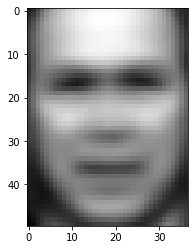

In [24]:
mean_face = np.reshape(faces.data.mean(axis=0), (50,37))
plt.imshow(mean_face, cmap=plt.cm.gray)

Plot the first 5 PCA components

In [37]:
num_dimensions = 5
first5 = pd.DataFrame(data_projected).iloc[:,0:num_dimensions]
first5.shape

(1288, 5)

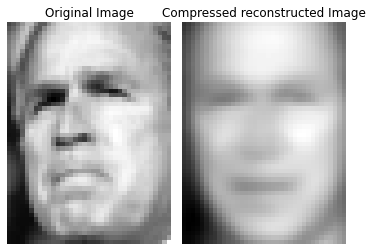

In [44]:
image_original = faces.images[12];
image_compressed = first5.iloc[12];
image_reconstructed = pca.mean_.copy(); 

for i in range(num_dimensions):
    image_reconstructed += pca.components_[i] * image_compressed[i]
    
fig, ax = plt.subplots(1, 2, figsize = (5,5))
ax[0].imshow(image_original, cmap=plt.cm.gray)
ax[0].set_title('Original Image')
ax[1].imshow(image_reconstructed.reshape(faces.images[0].shape), cmap=plt.cm.gray)
ax[1].set_title('Compressed reconstructed Image')
for ax in fig.axes:
    ax.axis('off')
plt.tight_layout()

Last PCA

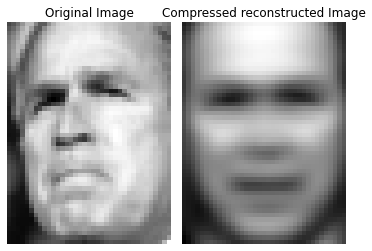

In [51]:
num_dimensions = 1
first = pd.DataFrame(data_projected).iloc[:,-1]
image_original = faces.images[12];
image_compressed = first.iloc[12];

image_reconstructed = pca.mean_.copy(); 

for i in range(num_dimensions):
    if num_dimensions == 1:
        image_reconstructed += pca.components_[i] * image_compressed
    else:
        image_reconstructed += pca.components_[i] * image_compressed[i]
    
fig, ax = plt.subplots(1, 2, figsize = (5,5))
ax[0].imshow(image_original, cmap=plt.cm.gray)
ax[0].set_title('Original Image')
ax[1].imshow(image_reconstructed.reshape(faces.images[0].shape), cmap=plt.cm.gray)
ax[1].set_title('Compressed reconstructed Image')
for ax in fig.axes:
    ax.axis('off')
plt.tight_layout()

### Choose the number of PCA

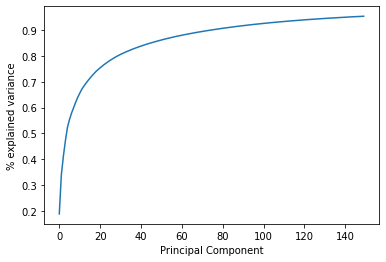

In [52]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Principal Component'); plt.ylabel('% explained variance');

In [55]:
value = (pd.DataFrame(np.cumsum(pca.explained_variance_ratio_)) <= 0.75).sum()[0]
print(f"The fisrt {value} components represent 75%")

The fisrt 20 components represent 75%


In [57]:
value = (pd.DataFrame(np.cumsum(pca.explained_variance_ratio_)) <= 0.80).sum()[0]
print(f"The fisrt {value} components represent 90%")

The fisrt 29 components represent 90%


### Apply model

In [67]:
X_train, X_test, y_train, y_test = train_test_split(img_reshaped, faces.target, test_size=0.3, random_state=0)

In [68]:
final_pipe = Pipeline([
    ('pca', PCA()),
    ('svc', SVC())])

In [70]:
param_distributions={
    # Access any component of the pipeline, as far back as you want
    'pca__n_components': stats.randint(200, 500),
    'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'svc__C': stats.loguniform(10, 10000),
    'svc__gamma': stats.loguniform(0.0001, 0.1)}

grid_search = RandomizedSearchCV(
    final_pipe,
    param_distributions=param_distributions,
    scoring='f1_weighted',
    n_iter=5,  # number of draws
    cv=5, n_jobs=-1)

grid_search.fit(X_train, y_train)
grid_search.best_estimator_

Pipeline(steps=[('pca', PCA(n_components=326)),
                ('svc',
                 SVC(C=6956.149701314322, gamma=0.0003376796068058658,
                     kernel='poly'))])

In [72]:
model = grid_search.best_estimator_
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.6925064599483204

In [73]:
grid_search.best_params_['pca__n_components']

326